In [1]:
dic={
'NP_416780.1':'nuoM',
'NP_416788.1':'nuoE',
'NP_416785.1':'nuoH',
'NP_416784.1':'nuoI',
'NP_416782.1':'nuoK',
'NP_416791.3':'nuoA',
'NP_416779.2':'nuoN',
'NP_416786.4':'nuoG',
'NP_416783.1':'nuoJ',
'NP_416787.1':'nuoF',
'NP_416781.1':'nuoL',
'NP_414632.1':'murG',
'NP_414627.1':'murE',
'NP_418403.1':'murB',
'NP_414633.1':'murC',
'NP_414630.1':'murD',
'NP_414628.1':'murF',
'NP_417656.1':'murA'}

In [54]:
import pandas as pd

test_results=pd.read_csv('info_df.csv', index_col=0).replace(dic)

In [55]:
test_results

,interactorA,interactorB,third_protein_info,PPcorrelation,third_proteins,third_proteins_len,av_partial,interactor_pair,combined_score,interaction_score
49,nuoN,nuoH,"[['NP_414627.1', 0.7783926097875581, 0.0682232...",0.840596,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",8,0.887862,NP_416779.2-NP_416785.1,1.728458,1.728458
75,nuoK,nuoJ,"[['NP_414627.1', 0.7768745245958497, nan], ['N...",0.901377,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",4,0.801950,NP_416782.1-NP_416783.1,1.703327,1.703327
43,murC,murA,"[['NP_414627.1', 0.9080836431631812, 0.0046795...",0.782364,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",9,0.811967,NP_414633.1-NP_417656.1,1.594330,1.594330
45,nuoN,nuoM,"[['NP_414627.1', 0.8846000354715885, 0.0035171...",0.775014,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",15,0.810393,NP_416779.2-NP_416780.1,1.585407,1.585407
36,murG,murA,"[['NP_414627.1', 0.9424566334204055, 0.0014788...",0.846520,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",9,0.736133,NP_414632.1-NP_417656.1,1.582653,1.582653
...,...,...,...,...,...,...,...,...,...,...
31,murG,nuoN,"[['NP_414627.1', -0.8515035016887381, 0.007301...",-0.294507,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",10,-0.563730,NP_414632.1-NP_416779.2,-0.858237,-0.858237
103,murA,murB,"[['NP_414627.1', -0.8716599207549938, 0.010563...",-0.260107,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",9,-0.615789,NP_417656.1-NP_418403.1,-0.875896,-0.875896
48,nuoN,nuoI,"[['NP_414627.1', -0.38358436150430303, 0.52386...",-0.365435,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",7,-0.653329,NP_416779.2-NP_416784.1,-1.018764,-1.018764
64,nuoM,murA,"[['NP_414627.1', -0.9026031846682252, 0.005392...",-0.407396,"['NP_414627.1', 'NP_414628.1', 'NP_414630.1', ...",9,-0.741778,NP_416780.1-NP_417656.1,-1.149173,-1.149173


In [95]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import community.community_louvain as community_louvain
import math
import numpy as np
from tqdm import tqdm
import ast
import pickle

def plot_network(G):
    pos = nx.circular_layout(G) # position the nodes using the circular layout
    edges = G.edges(data=True)
    plt.figure(figsize=(11,11), facecolor=[0.7, 0.7, 0.7, 0.4], dpi=400)
    nx.draw(G, pos, with_labels=True, node_size=4500, font_size=20, node_color='lightgrey', edgecolors='black')
    plt.axis('off')
    plt.show()

def create_G(df):
    G = nx.Graph(name='Protein Interaction Graph')
    interactions = np.array(df)
    max_score = interactions[:, 2].max()  # Get the maximum score from the 'combined_score' column
    for i in range(len(interactions)):
        interaction = interactions[i]
        a = interaction[0] # protein a node
        b = interaction[1] # protein b node
        score = float(interaction[2]) # score as weighted edge where high scores = low weight
        
        # Normalize the score between 0 and 1
        normalized_score = score / max_score if max_score != 0 else 0  # Avoid division by zero
        G.add_edge(a, b, weight=score, width=normalized_score)
    
    # Remove isolated nodes with zero degree (if any)
    isolated_nodes = list(nx.isolates(G))
    G.remove_nodes_from(isolated_nodes)
    
    return G

def find_communities(G, resolution):
    communities = {}
    
    # Check for negative node degrees or edge weights
    for node in G.nodes:
        if G.degree(node) < 0:
            raise ValueError(f"Bad node degree: {node} has negative degree.")
    
    for u, v, weight in G.edges(data=True):
        if weight.get('weight', 1) < 0:
            weight['weight'] = 0  # You can set it to 0 or a small value like 0.01 if needed.    
    partition = community_louvain.best_partition(G, resolution=resolution)

    # For each community in the partition...
    for community in set(partition.values()):
        # Create a subgraph of the community
        subgraph = G.subgraph([node for node, comm in partition.items() if comm == community])
        communities[f'Community_{community}'] = subgraph
    
    return communities

def plot_all_communities(communities):
    # Calculate the layout of the subplots
    N_coms = len(communities)
    sqrt_N_coms = math.sqrt(N_coms)
    n_rows = math.ceil(sqrt_N_coms)
    n_cols = math.ceil(N_coms / n_rows)

    # Create the subplots
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(80, 80), dpi=100)

    # For each community...
    for i, (key, community) in enumerate(communities.items()):
        # Calculate the position of the subplot
        row = i // n_cols
        col = i % n_cols

        # Get the current axes
        ax = axs[row, col] if N_coms > 1 else axs

        # Plot the community on the subplot
        pos = nx.circular_layout(community)
        edges = community.edges(data=True)
        nx.draw(community, pos, with_labels=True, node_size=4500, node_color='lightgrey', edgecolors='black', ax=ax)

        # Set the title of the subplot to the key of the community
        ax.set_title(f'{key}', fontsize=42)

        # Hide the axis
        ax.axis('off')

    # Adjust the layout
    plt.tight_layout()
    plt.show()


In [96]:
#df=test_results[test_results['interaction_score']>=0][['interactorA','interactorB','interaction_score']]
df=test_results[['interactorA','interactorB','interaction_score']]
G=create_G(df)
communities=find_communities(G,1)

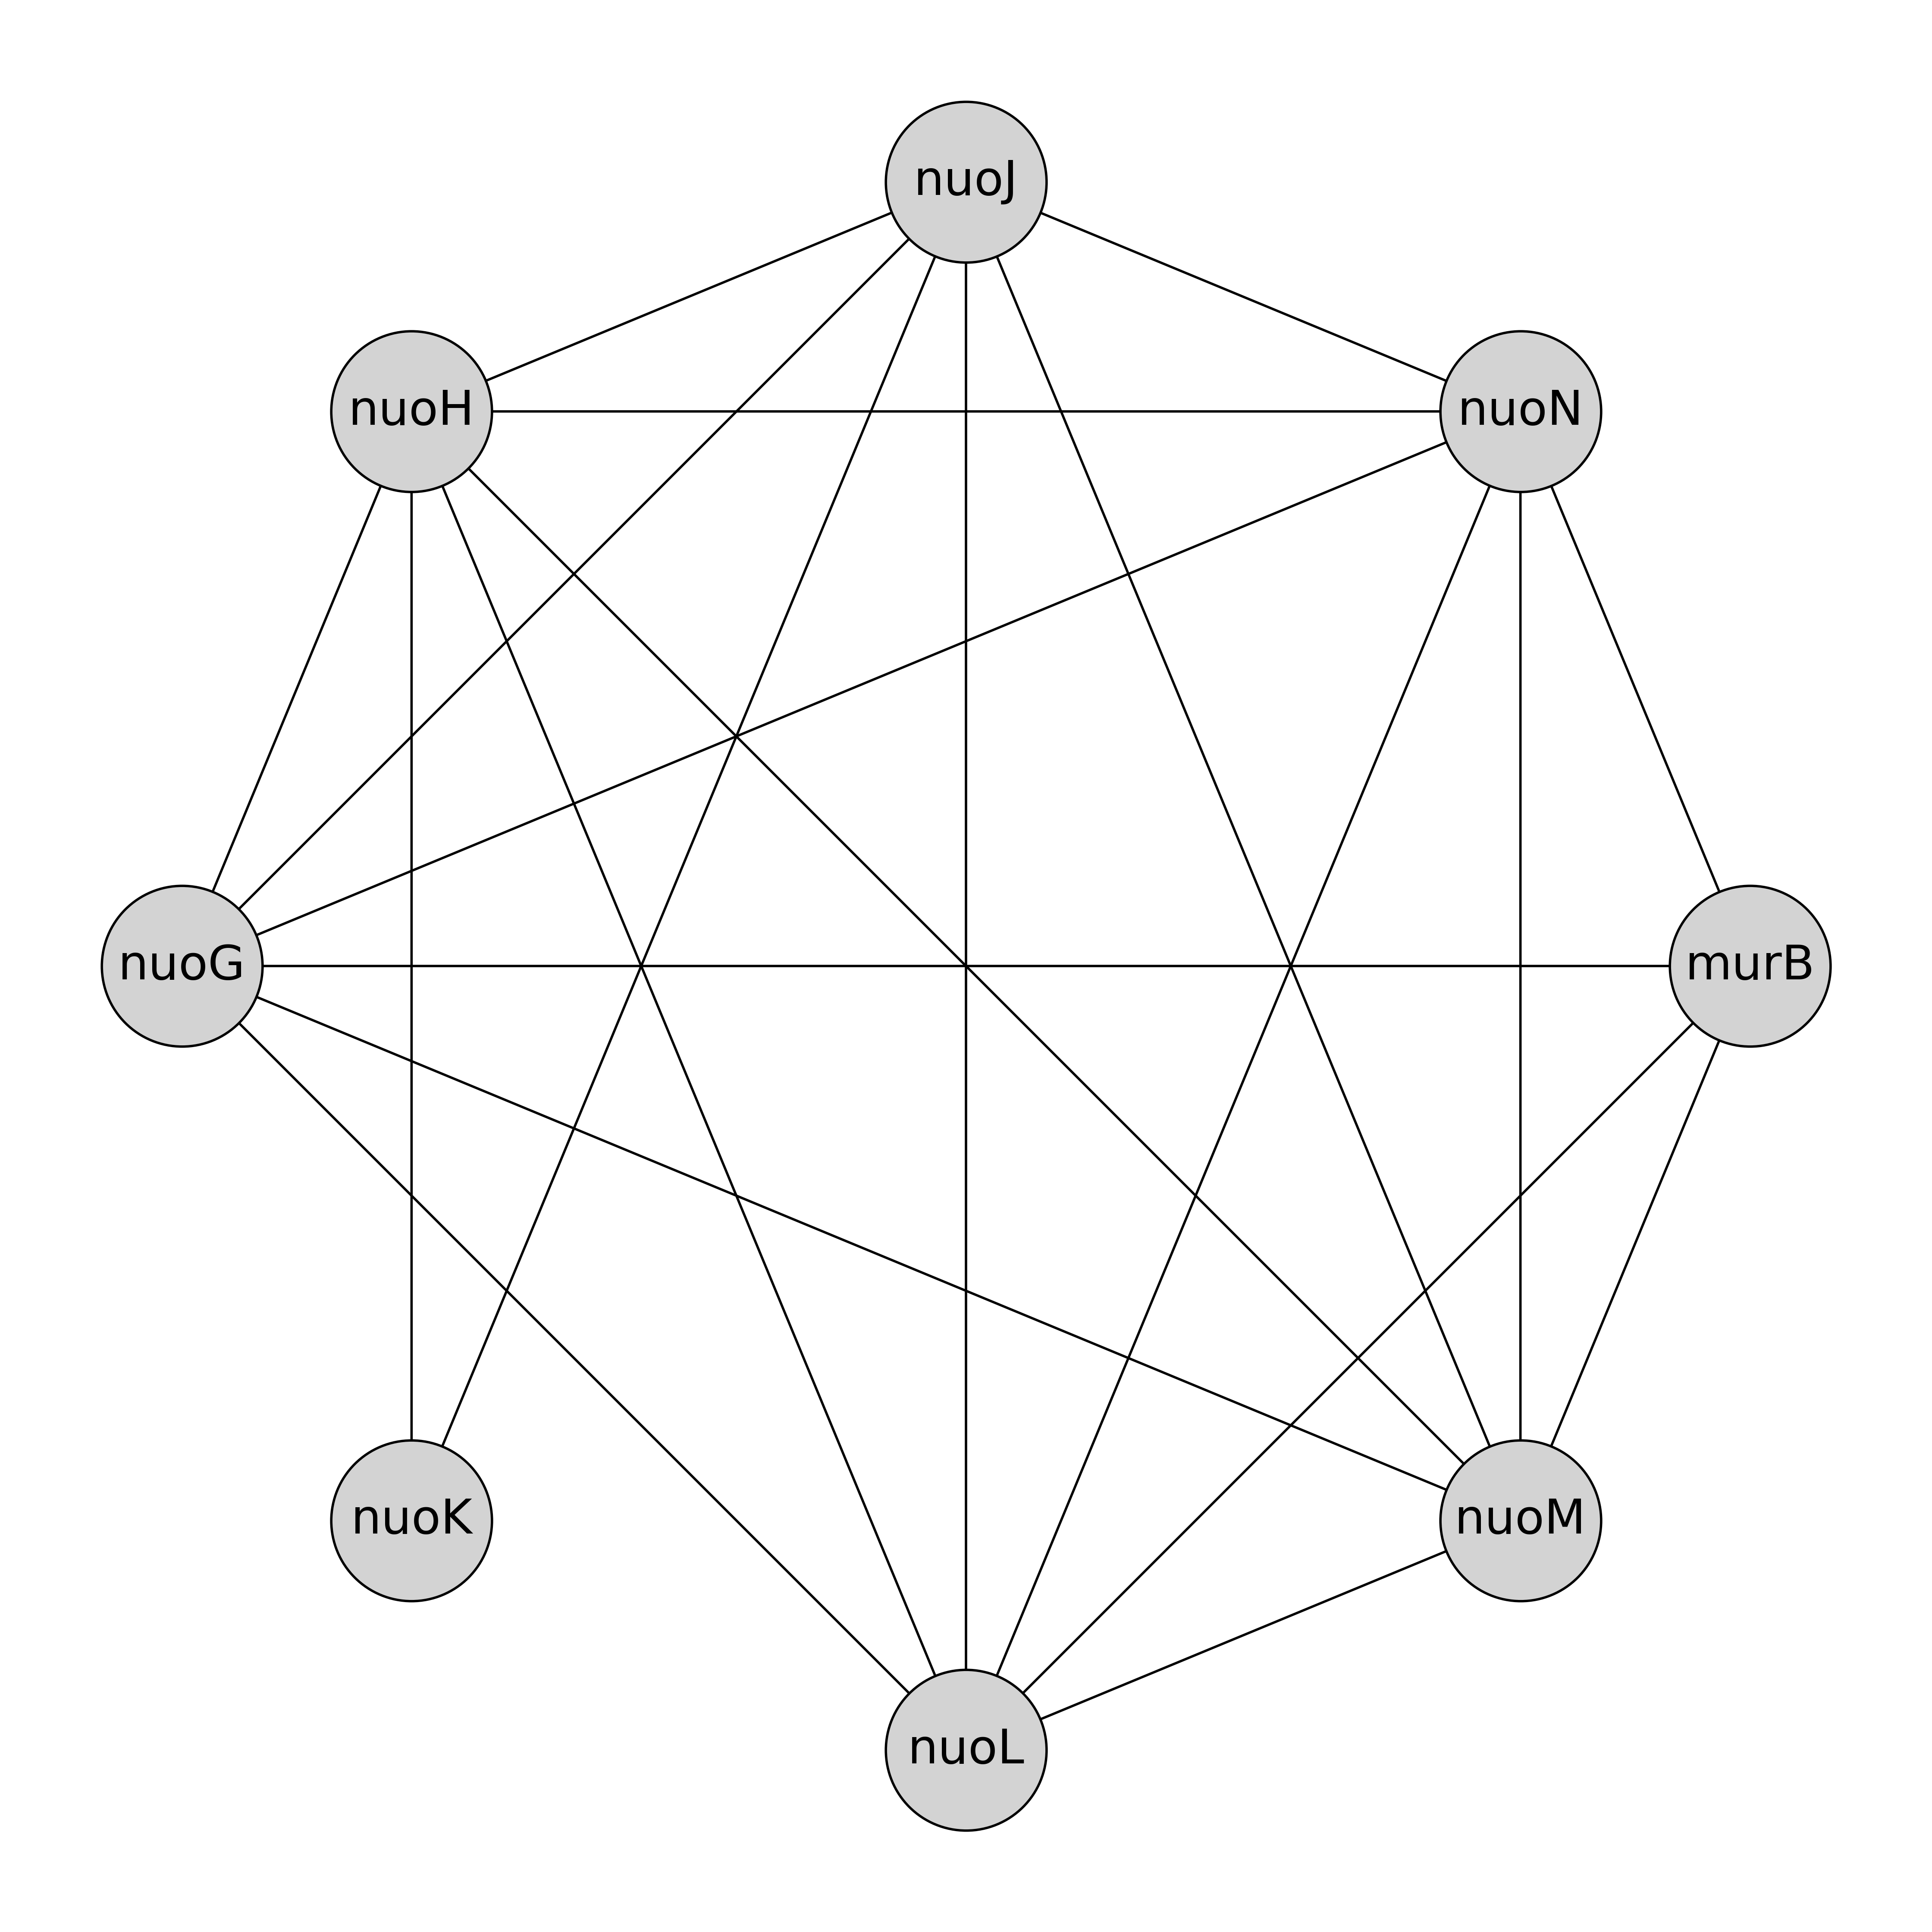

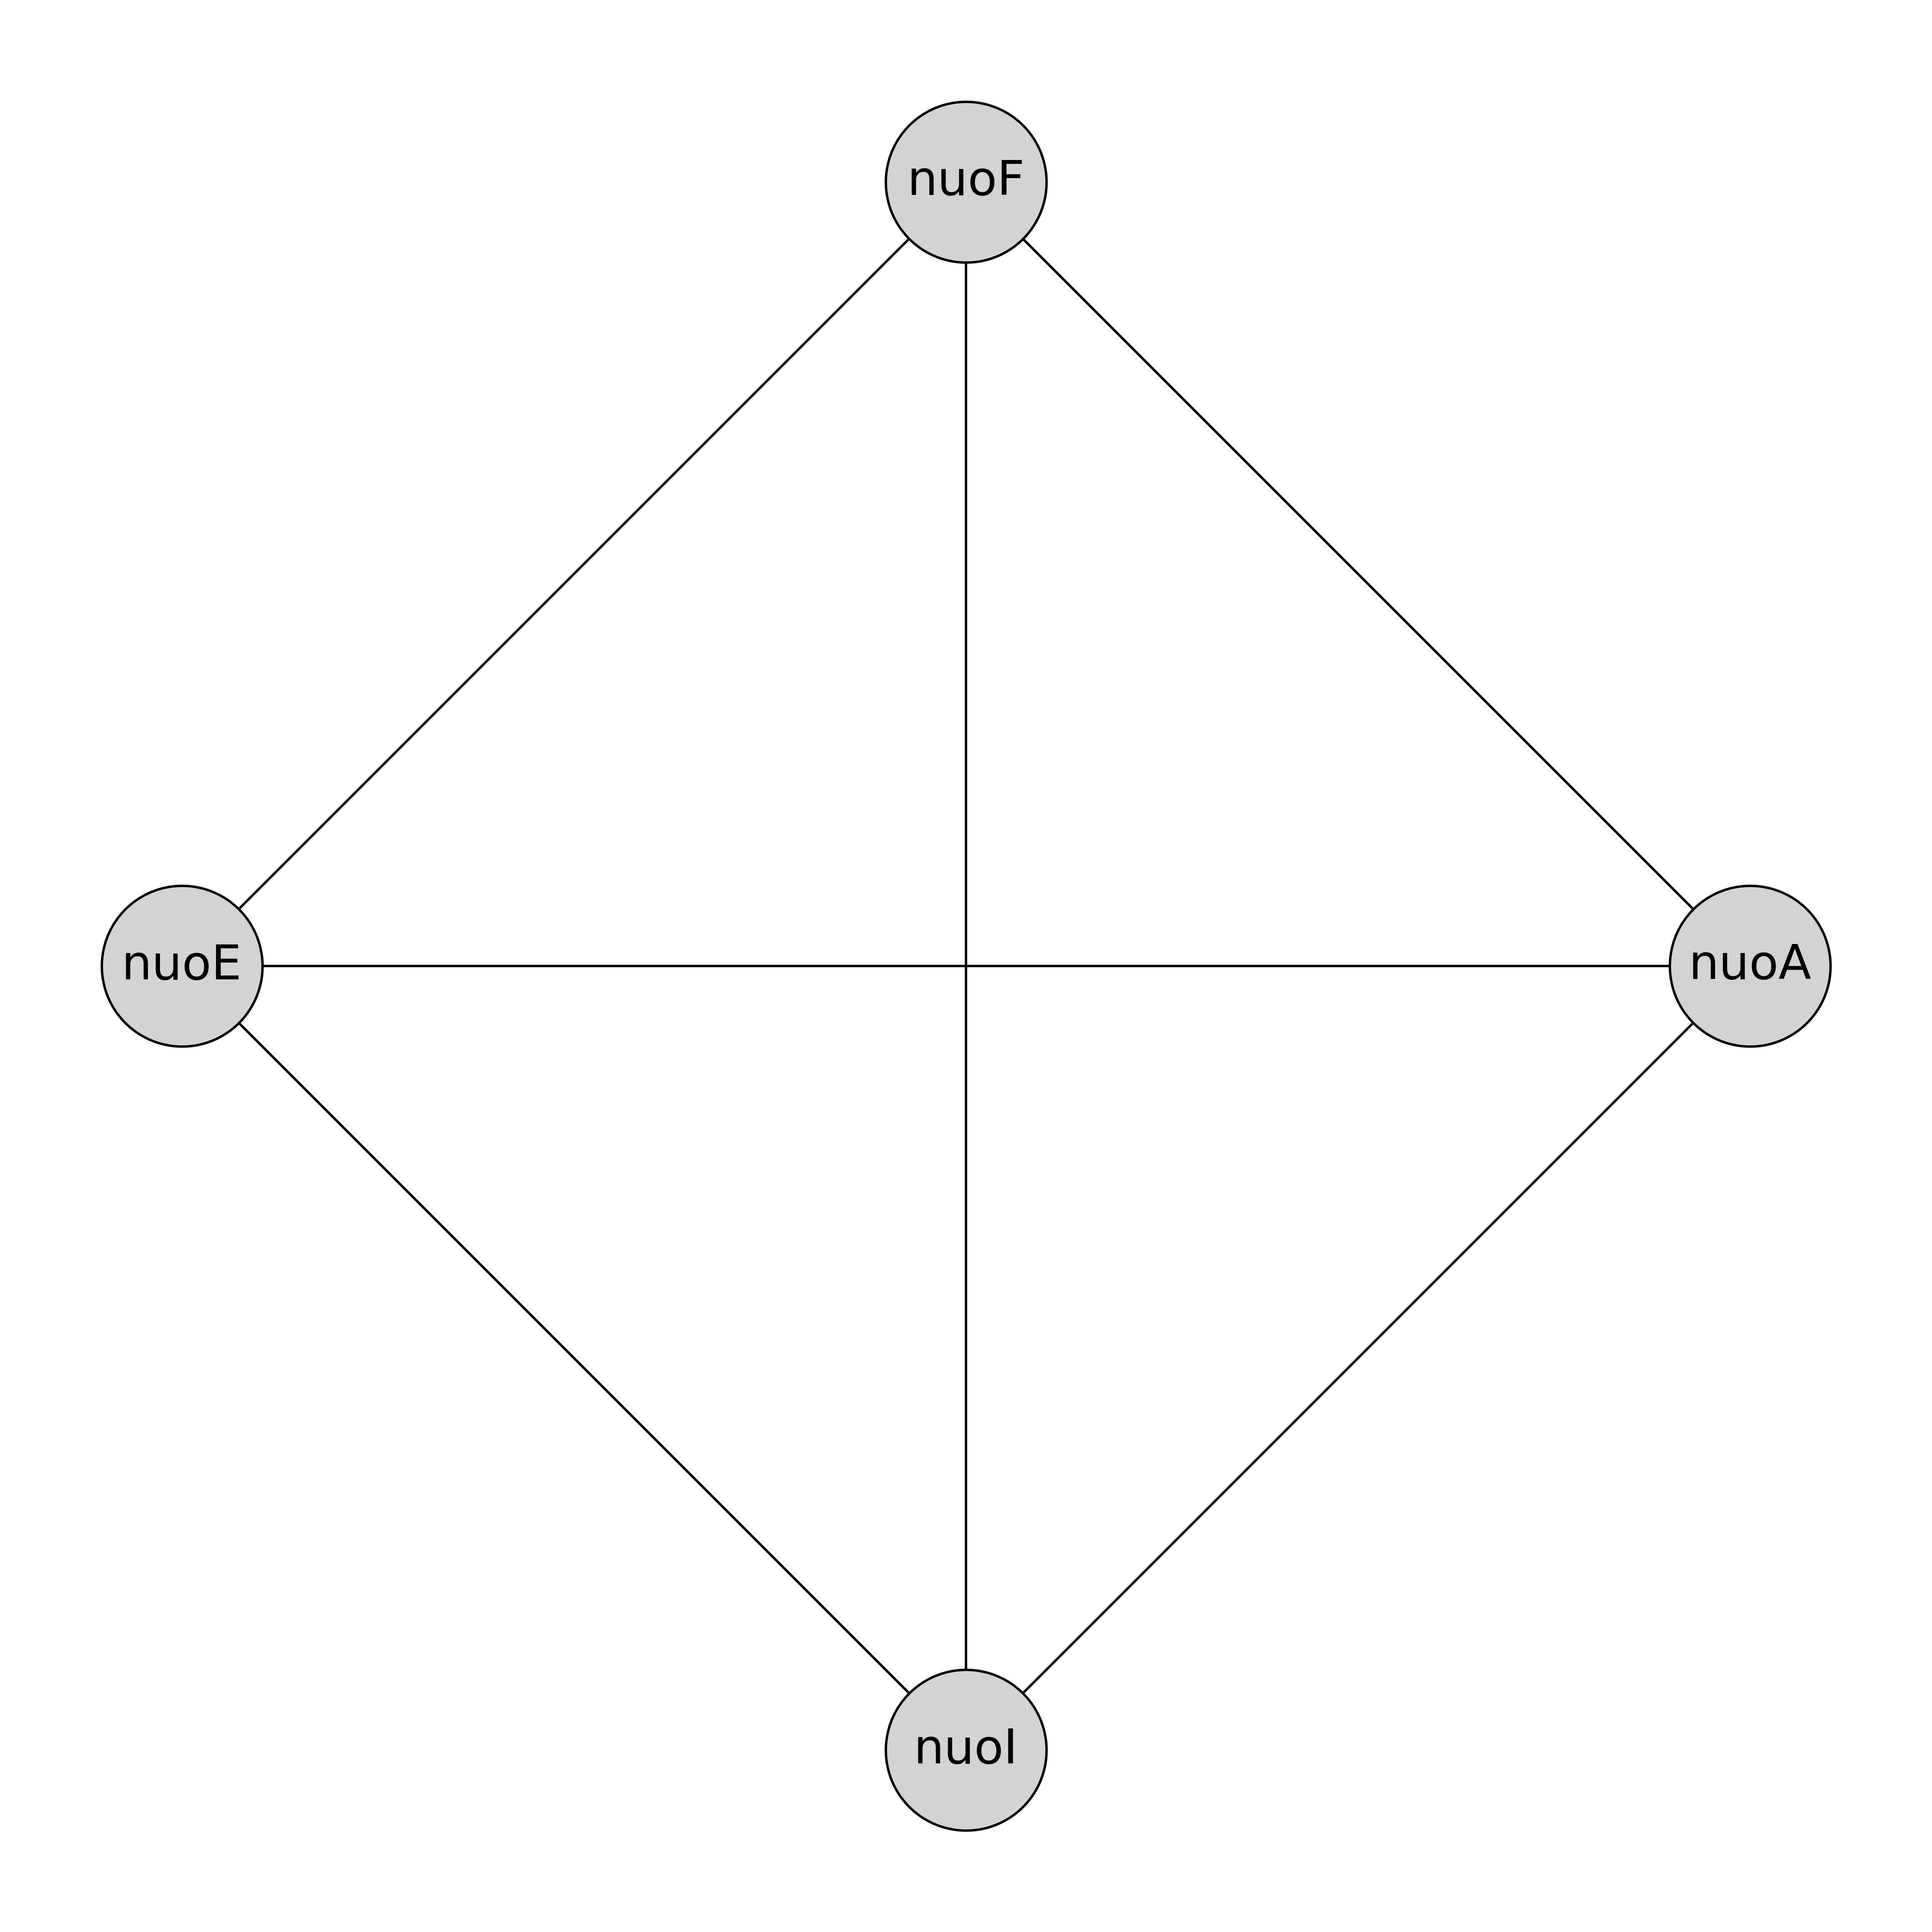

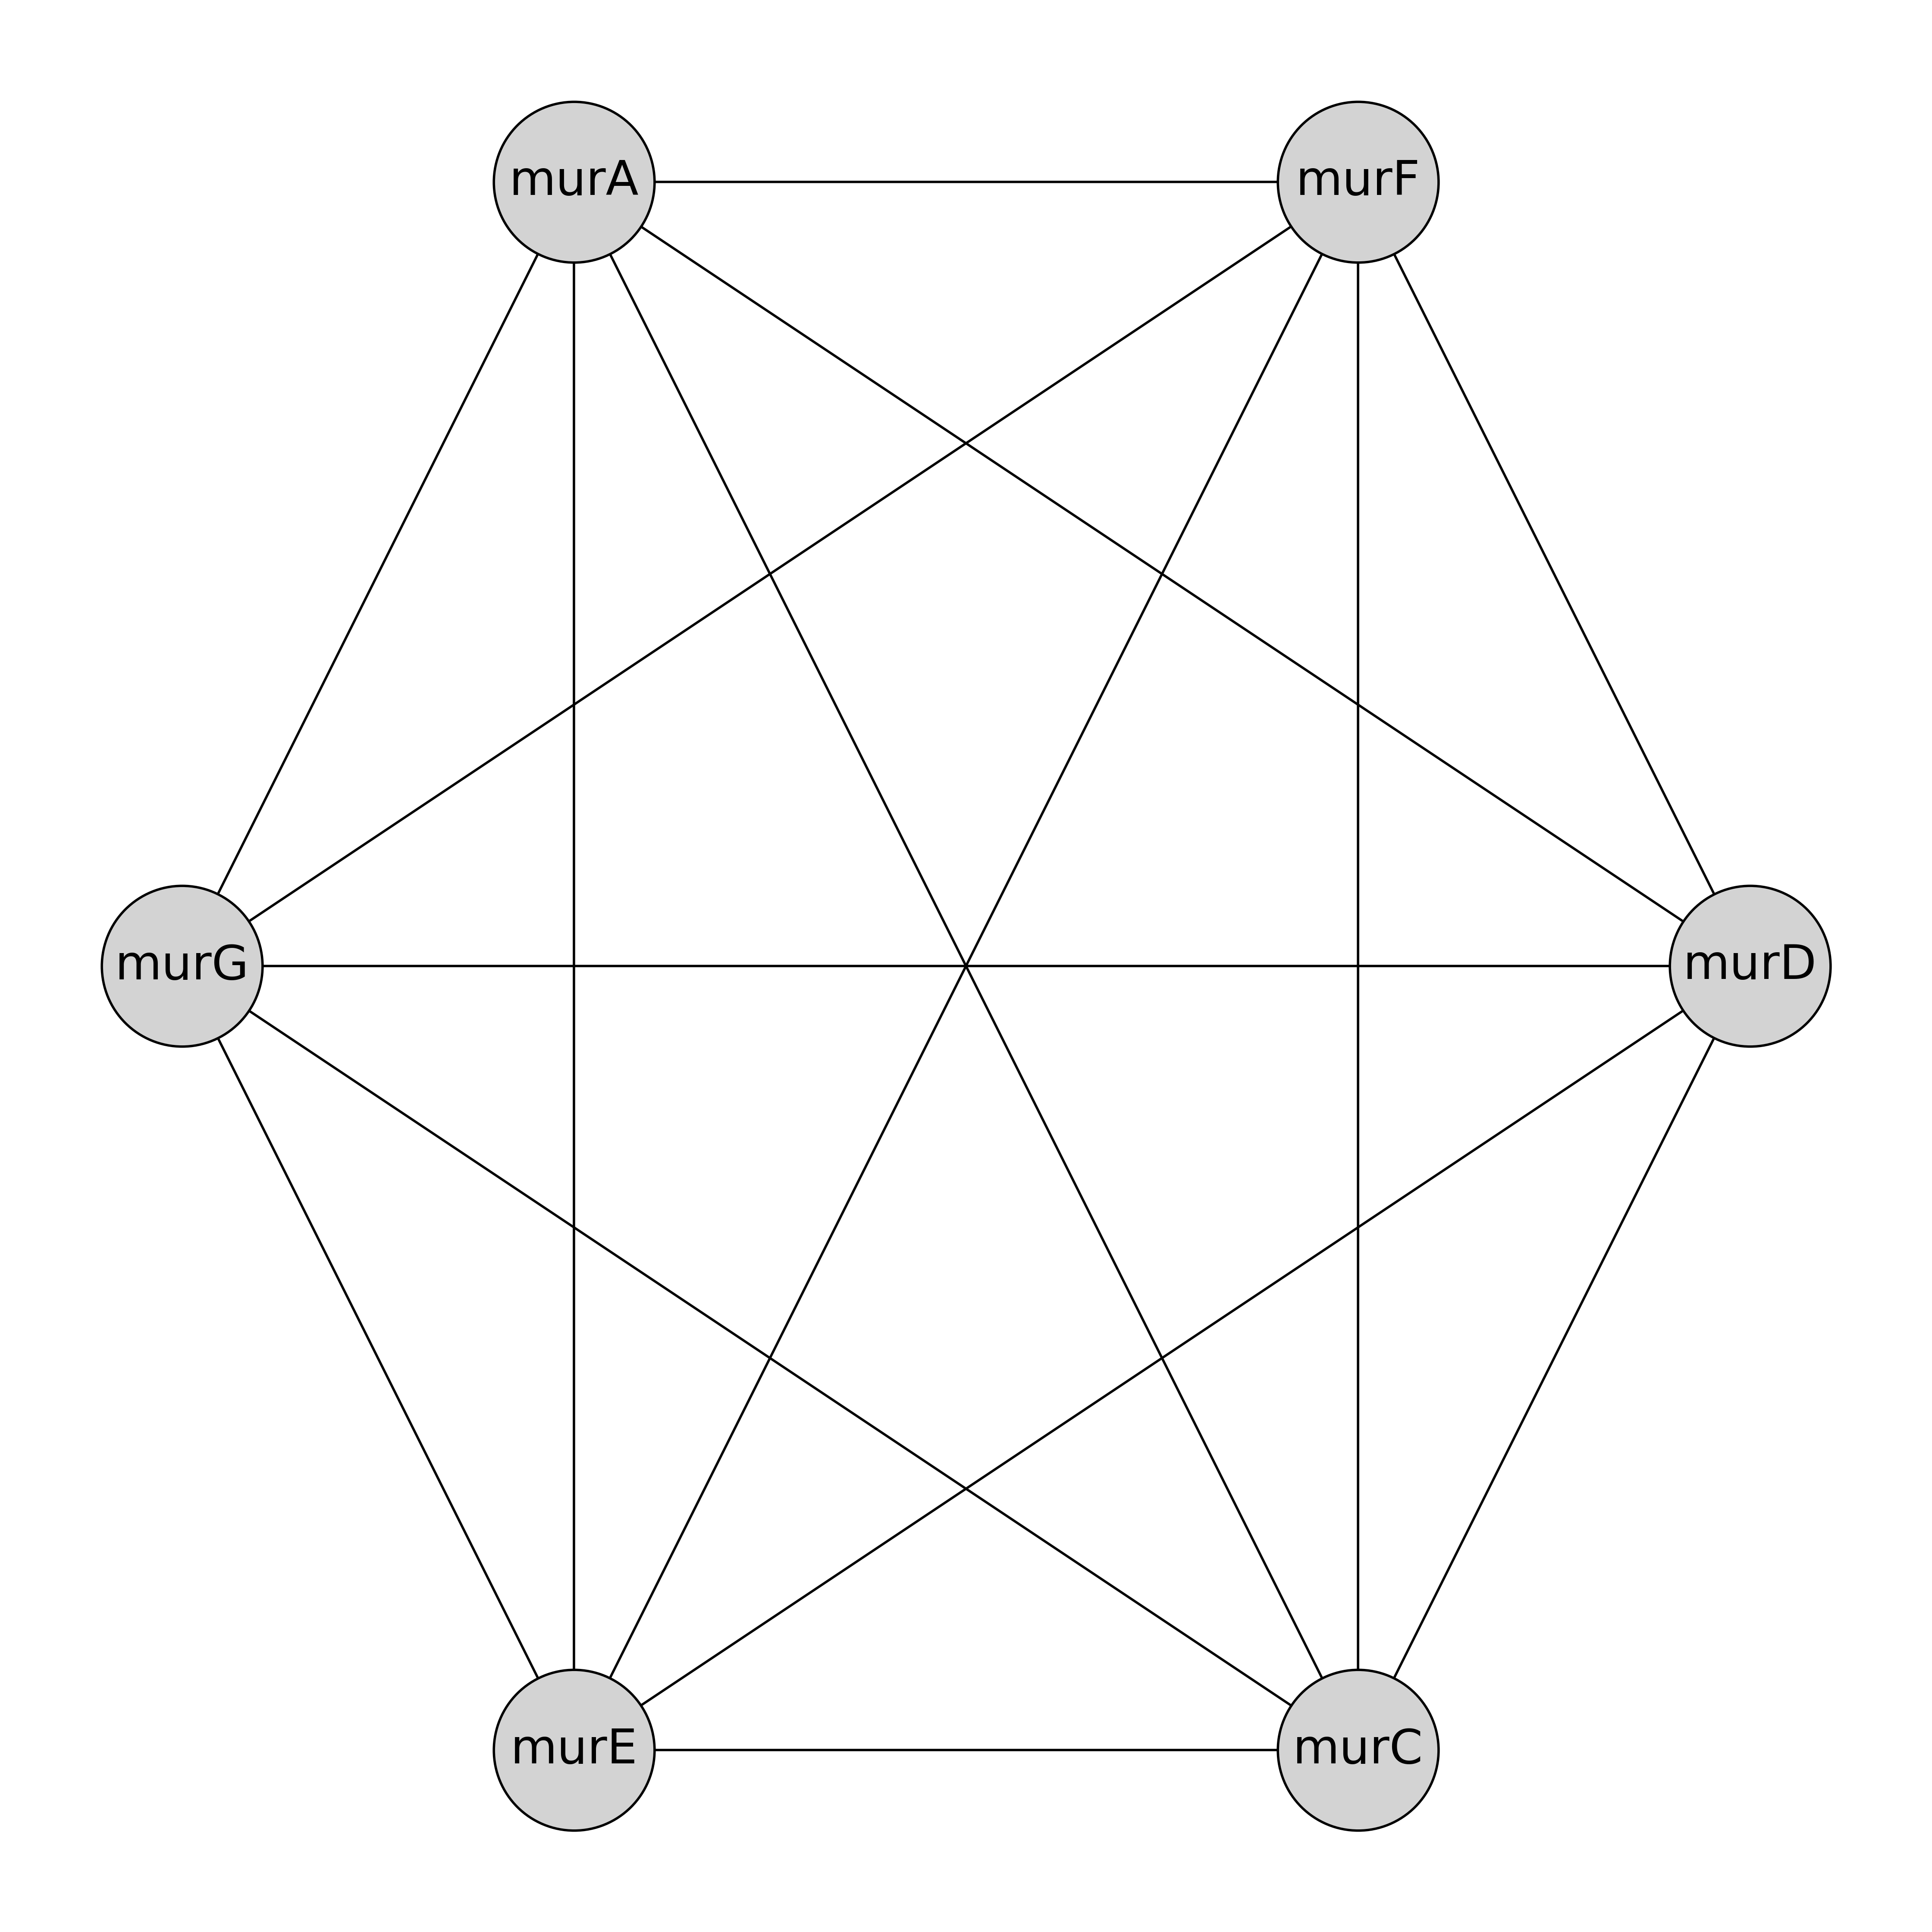

In [97]:
for com in communities.keys():
    plot_network(communities[com])

Average interaction score for same-prefix pairs: 0.6097878966509133
Average interaction score for different-prefix pairs: -0.06136172807417184


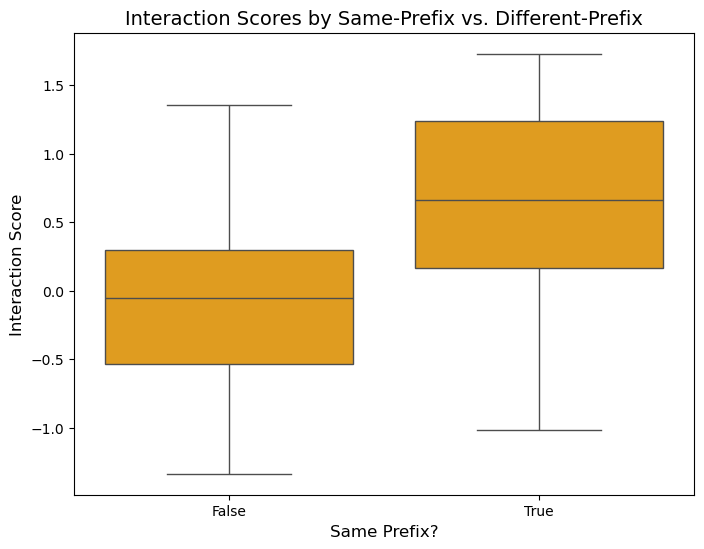

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to extract the prefix (first 3 characters) from protein names
def extract_prefix(protein_name):
    return protein_name[:3]

# Create a copy of the dataframe to avoid SettingWithCopyWarning
df_copy = df.copy()

# Extract prefixes for both interactors
df_copy['prefix_A'] = df_copy['interactorA'].apply(extract_prefix)
df_copy['prefix_B'] = df_copy['interactorB'].apply(extract_prefix)

# Create a new column 'same_prefix' to indicate if both interactors have the same prefix
df_copy['same_prefix'] = df_copy['prefix_A'] == df_copy['prefix_B']

# Calculate average interaction score for same-prefix vs. different-prefix pairs
same_prefix_score = df_copy[df_copy['same_prefix']]['interaction_score'].mean()
different_prefix_score = df_copy[~df_copy['same_prefix']]['interaction_score'].mean()

print(f"Average interaction score for same-prefix pairs: {same_prefix_score}")
print(f"Average interaction score for different-prefix pairs: {different_prefix_score}")

# Plotting box plot of interaction scores by same_prefix category
plt.figure(figsize=(8, 6))
sns.boxplot(x='same_prefix', y='interaction_score', data=df_copy, color='orange')

# Adding labels and title
plt.xlabel('Same Prefix?', fontsize=12)
plt.ylabel('Interaction Score', fontsize=12)
plt.title('Interaction Scores by Same-Prefix vs. Different-Prefix', fontsize=14)

plt.show()
